In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
import warnings
from matplotlib.lines import Line2D
import scipy.stats
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

from IPython.display import HTML
config = dict(server='ABR-RIPLEYA-D1',
    port=      1433,
    database=  'boydcartridgePQ2022',
    )

conn_str = ('SERVER={server};' +
            'Database={database};' +
            'TRUSTED_CONNECTION=yes')

conn = pyodbc.connect(
    r'DRIVER={SQL Server};' +
    conn_str.format(**config)
    )

print(conn_str)

SERVER={server};Database={database};TRUSTED_CONNECTION=yes


In [56]:
colorDict  = {1:'#FF0000',#Red 1
              2:'#00B050',#Green 2
              3:'#0070C0',#Blue 3
              4:'#7030A0',#Purple 4
              5:'#808080',#Light Grey 5
              6:'#FF6600',#Orange 6
              7:'#FFCC00',#Yellow 7
              8:'#9999FF',#Light Purple 8
              9:'#333333',#Black 9
              10:'#808000',#Goldish 10
              11:'#FF99CC',#Hot Pink 11
              12:'#003300',#Dark Green 12
            }

##Function to Get Channel Data (i.e. Green Raw, Red Normalized etc.)
def getSQLData_Channel(color, dtype, assay, start_time_filter, end_date_filter,system,assay_version,cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_"+color+"_"+dtype+"_Master]"+
             "where ([Result Code] like '%"+assay+"%') and [Start Time]>'"+start_time_filter+"'"+
             " and [Start Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+
             "%' and ([Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    print("--"*30)
    
    
    df = pd.read_sql(query, conn)
    ##Add Prefix Column
    return df

##Function to Get Channel Data (i.e. Green Raw, Red Normalized etc.)                          
def getSQLData_COC(assay, start_time_filter, end_date_filter, system, assay_version, cartridge_lot_filter, cartridge_lot_filter_b, cartridge_lot_filter_c, cartridge_lot_filter_d):
    query = ("Select * from [dbo].[NeuMoDx_System_Master_Table]"+
             " where ([Result Code] like '%"+assay+"%') and [Start Date Time]>'"+start_time_filter+"'"+
             " and [Start Date Time] < '"+end_date_filter+"' and [N500 Serial Number] like '%"+system+"%'"+
             " and [Assay Version] like '%"+assay_version+"%' and ([Pcr Cartridge Barcode] like '%"+cartridge_lot_filter+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_b+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_c+
             "%' OR [Pcr Cartridge Barcode] like '%"+cartridge_lot_filter_d+"%')")
    print("Query:", query)
    df = pd.read_sql(query, conn)
    print("--"*30)
    
    return df.set_index(['PCR Module Serial', 'Pcr Cartridge Lane'])


NormDataDict_PCR = {}
RawDataDict_PCR = {}
SecondDataDict_PCR = {}
COC_PCR = getSQLData_COC('HIV', '2022-04-07', '2022-12-31', '', '', '', '', '', '').drop_duplicates(['Test Guid'])
#COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
for channel in ['Green','Yellow']:
    NormDataDict_PCR[channel] = getSQLData_Channel(channel,'Normalized','HIV', '2022-04-07', '2022-12-31', '', '', '', '', '', '').drop_duplicates(['Test Guid'])
    RawDataDict_PCR[channel] = getSQLData_Channel(channel,'Raw', 'HIV', '2022-04-07', '2022-12-31', '', '', '', '', '', '').drop_duplicates(['Test Guid'])
    SecondDataDict_PCR[channel]= getSQLData_Channel(channel,'2nd','HIV', '2022-04-07', '2022-12-31', '', '', '', '', '', '').drop_duplicates(['Test Guid'])
    NormDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    RawDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    SecondDataDict_PCR[channel].set_index(['XPCR Module Serial','Cartridge Lane', 'Test Guid'],inplace=True)
    NormDataDict_PCR[channel].sort_index(inplace=True)

Query: Select * from [dbo].[NeuMoDx_System_Master_Table] where ([Result Code] like '%HIV%') and [Start Date Time]>'2022-04-07' and [Start Date Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%' OR [Pcr Cartridge Barcode] like '%%')
------------------------------------------------------------
Query: Select * from [dbo].[NeuMoDx_Green_Normalized_Master]where ([Result Code] like '%HIV%') and [Start Time]>'2022-04-07' and [Start Time] < '2022-12-31' and [N500 Serial Number] like '%%' and [Assay Version] like '%%' and ([Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%' OR [Cartridge Barcode] like '%%')
------------------------------------------------------------
Query: Select * from [dbo].[NeuMoDx_Green_Raw_Master]where ([Result Code] like '%HIV%') and [Start Time]>'2022-04-07' and [Start Time] < '202

In [57]:
##Returns Consumable Information for each module included in Dataset Takes Chain of Custody Data as input
def generateLotTable(data):
    LotDataBase = data.sort_values('Start Date Time')

    #stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    #results_Stats = ['Amp','NotAmp','NoResult','Sample Size']
    #LotDataBase['Run Number'] = np.nan
    for mod in LotDataBase.index.unique(0):
        LotDataBase.loc[mod, 'Time Difference'] = LotDataBase.loc[mod, 'Start Date Time'].diff().values / np.timedelta64(1, 's')
        LotDataBase.loc[mod, 'Time Difference'] = np.where(LotDataBase.loc[mod, 'Time Difference'].isnull(),50000,LotDataBase.loc[mod, 'Time Difference'])
        LotDataBase.loc[mod, 'New Run?'] = np.where(LotDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        LotDataBase.loc[(mod, (LotDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(LotDataBase.loc[mod, LotDataBase['New Run?']==1,:])+1)
        LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']] = LotDataBase.loc[mod,['Run Number','Start Date Time','Time Difference','New Run?']].fillna(method='ffill').values

    LotDataBase.reset_index(inplace=True)
    LotDataBase['Date'] = LotDataBase['Start Date Time'].dt.date
    LotDataBase.set_index(['PCR Module Serial', 'Run Number', 'Date'],inplace=True)
    LotDataBase['Cartridge Lot'] = LotDataBase['Pcr Cartridge Barcode'].str[18:24]
    LotDataBase['Cartridge Serial'] = LotDataBase['Pcr Cartridge Barcode'].str[27:32]
    LotDataBase['Test Strip Lot'] = LotDataBase['Test Strip NeuMoDx Barcode'].str[18:24]
    LotDataBase['LDT Master Mix Lot'] = LotDataBase['Test Strip LDT Master Mix Barcode'].str[18:24]
    LotDataBase['Extraction Plate Lot'] = LotDataBase['Capture Plate Barcode'].str[18:24]
    LotDataBase['Buffer Lot'] = LotDataBase['Buffer Barcode'].str[18:24]                                                 
    LotDataBase['Release Lot'] = LotDataBase['Release Reagent Barcode'].str[18:24]
    LotDataBase['Wash Lot'] = LotDataBase['Wash Reagent Barcode'].str[18:24]
    


    Lots = ['Cartridge Lot', 'Cartridge Serial', 'Test Strip Lot', 'Extraction Plate Lot', 'Buffer Lot', 'Release Lot',  'Wash Lot', 'Result Code']
    #display(LotDataBase['LotDataBase Strip Lot'].groupby(level=[0,1]).agg('unique'))
    LotDataBase_aggs = {}
    for lot_type in Lots:
        LotDataBase_by_run_agg = LotDataBase[lot_type].groupby(level=[0,1,2]).agg('unique').to_frame()
        LotDataBase_by_mod_agg = LotDataBase[lot_type].groupby(level=[0]).agg('unique').to_frame()
        LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()
        #LotDataBase_by_date_agg = LotDataBase[lot_type].groupby(level=[2]).agg('unique').to_frame()    

        LotDataBase_by_mod_agg['Run Number'] = 'Combined'
        LotDataBase_by_mod_agg['Date'] = 'Combined'
        
        LotDataBase_by_date_agg['Run Number'] = 'Combined'
        LotDataBase_by_date_agg['PCR Module Serial'] = 'Combined'
        
        LotDataBase_by_mod_agg.set_index(['Run Number','Date'],append=True,inplace=True)
        LotDataBase_by_date_agg.set_index(['Run Number', 'PCR Module Serial'],append=True,inplace=True)
        LotDataBase_by_date_agg = LotDataBase_by_date_agg.reorder_levels(['PCR Module Serial', 'Run Number', 'Date'],axis=0)
        LotDataBase_agg = pd.concat([LotDataBase_by_run_agg,LotDataBase_by_mod_agg,LotDataBase_by_date_agg],axis=0).sort_index()
        #LotDataBase_agg.sort_index(axis=1,inplace=True)
        #LotDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
        LotDataBase_aggs[lot_type] = LotDataBase_agg
    consumables = pd.concat([LotDataBase_aggs[x] for x in LotDataBase_aggs],axis=1)
    consumables.index.names = ['XPCR Module Serial', 'Run Number','Date']
    consumables.columns = pd.MultiIndex.from_tuples([(lot, '', '') for lot in consumables.columns])
    return consumables, LotDataBase[Lots+['Test Guid', 'LHPA ADP Position', 'LHPB ADP Position', 'LHPC ADP Position', 'Pcr Cartridge Lane']]

##Returns By Run Summary Information & Run Labeled Line Data for each module included in Dataset Takes Channel Data as input
def generateSummaryTable(data, channel):
    SummaryDataBase = data.sort_values('Start Time')

    stats = ['Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']
    results_Stats = ['Amp','NotAmp','NoResult','IND', 'UNR', 'Sample Size']
    #SummaryDataBase['Run Number'] = np.nan
    for mod in SummaryDataBase.index.unique(0):
        SummaryDataBase.loc[mod, 'Time Difference'] = SummaryDataBase.loc[mod, 'Start Time'].diff().values / np.timedelta64(1, 's')
        SummaryDataBase.loc[mod, 'Time Difference'] = np.where(SummaryDataBase.loc[mod, 'Time Difference'].isnull(),50000,SummaryDataBase.loc[mod, 'Time Difference'])
        SummaryDataBase.loc[mod, 'New Run?'] = np.where(SummaryDataBase.loc[mod, 'Time Difference']>3600,True,False) 
        SummaryDataBase.loc[(mod, (SummaryDataBase['New Run?']==1)), 'Run Number'] = np.arange(1, len(SummaryDataBase.loc[mod, SummaryDataBase['New Run?']==1,:])+1)
        SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']] = SummaryDataBase.loc[mod,['Run Number','Start Time','Time Difference','New Run?']].fillna(method='ffill').values

    SummaryDataBase['NotAmp'] = np.where(SummaryDataBase['Target Result']=='TargetNotAmplified',1,0)
    SummaryDataBase['Amp'] = np.where(SummaryDataBase['Target Result']=='TargetAmplified',1,0)
    SummaryDataBase['NoResult'] = np.where(SummaryDataBase['Target Result']=='NoResult',1,0)
    SummaryDataBase['IND'] = np.where(SummaryDataBase['Target Result']=='TargetIndeterminate',1,0)
    SummaryDataBase['UNR'] = np.where(SummaryDataBase['Target Result']=='TargetUnresolved',1,0)
    SummaryDataBase['Abort'] = np.where(SummaryDataBase['Target Result']=='TargetAborted',1,0)
    SummaryDataBase['Sample Size'] = SummaryDataBase[['NotAmp','Amp','NoResult','IND','UNR']].sum(axis=1)

    SummaryDataBase.loc[:,['NotAmp','Amp','IND','UNR','NoResult','Sample Size']]



    SummaryDataBase.reset_index(inplace=True)
    SummaryDataBase.set_index(['XPCR Module Serial','Run Number'],inplace=True)
    SummaryDataBase.loc[:,stats] =  SummaryDataBase.loc[:,stats].astype(float)

    SummaryDataBase.to_csv('SummaryDataBase.csv')

    agg_dict = {}
    agg_dict['Start Time'] = ['first','last']
    for stat in results_Stats:
        agg_dict[stat] = ['sum']
    for stat in stats:
        agg_dict[stat] = ['mean','std','count']
    agg_dict

    SummaryDataBase_by_run_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0,1]).agg(agg_dict)



    SummaryDataBase_by_mod_agg = SummaryDataBase[stats+results_Stats+['Start Time']].groupby(level=[0]).agg(agg_dict)


    SummaryDataBase_by_mod_agg['Run Number'] = 'Combined'
    SummaryDataBase_by_mod_agg.set_index('Run Number',append=True,inplace=True)

    SummaryDataBase_agg = pd.concat([SummaryDataBase_by_run_agg,SummaryDataBase_by_mod_agg],axis=0).sort_index()

    SummaryDataBase_agg[('Ct Calls','')] = SummaryDataBase_agg[('Ct','count')]
    for param in SummaryDataBase_agg.columns.unique(0):
        if param in stats:
            SummaryDataBase_agg[(param, '%CV')] = SummaryDataBase_agg[(param, 'std')] / SummaryDataBase_agg[(param, 'mean')]
            SummaryDataBase_agg.drop([(param,'count')],axis=1,inplace=True)
    SummaryDataBase_agg.sort_index(axis=1,inplace=True)
    SummaryDataBase_agg.set_index('Ct Calls',append=True,inplace=True)
    SummaryDataBase_agg.columns = pd.MultiIndex.from_tuples([(channel,x,y) for x,y in SummaryDataBase_agg.columns])
    SummaryDataBaseagg = SummaryDataBase_agg.loc[:,channel]
    SummaryDataBaseagg[('% Amp', '')] = SummaryDataBaseagg[('Amp', 'sum')] / (SummaryDataBaseagg[('Amp', 'sum')] + SummaryDataBaseagg[('NotAmp', 'sum')])
    SummaryDataBaseagg = SummaryDataBaseagg.loc[:,['Start Time', '% Amp', 'Amp','NotAmp','NoResult', 'IND', 'UNR', 'Sample Size', 'Ct', 'End Point Fluorescence', 'Max Peak Height', 'EPR']].droplevel(2,axis=0)
    SummaryDataBaseagg.columns = pd.MultiIndex.from_tuples([('Start Time', 'first sample'),
                                                 ('Start Time', 'last sample'),
                                                 ('% AMP', ''),
                                                 ('Amp', '') ,
                                                 ('NotAmp', '') ,
                                                 ('NoResult', ''),
                                                 ('UNR', '') ,
                                                 ('IND', '') ,
                                                 ('Sample Size', ''),
                                                 ('Ct', '%CV') ,
                                                 ('Ct', 'mean') ,
                                                 ('Ct', 'std') ,
                                                 ('End Point Fluorescence', '%CV') ,
                                                 ('End Point Fluorescence', 'mean') ,
                                                 ('End Point Fluorescence', 'std'),
                                                 ('Max Peak Height', '%CV') ,
                                                 ('Max Peak Height', 'mean') ,
                                                 ('Max Peak Height', 'std') ,
                                                 ('EPR', '%CV') ,
                                                 ('EPR', 'mean') ,
                                                 ('EPR', 'std')])
    return SummaryDataBaseagg, SummaryDataBase

In [58]:
COC_PCR = COC_PCR.loc[([x for x in COC_PCR.index.unique(0) if pd.isnull(x)==False],
                       [x for x in COC_PCR.index.unique(1) if pd.isnull(x)==False]),:]

#DF = generateLotTable(COC_PCR).join(generateSummaryTable(RawDataDict_PCR['Yellow'],'Yellow'))
channelData = {}    

channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')

channelData['Yellow'] =  generateSummaryTable(RawDataDict_PCR['Yellow'], 'Yellow')

consumables = generateLotTable(COC_PCR)

In [59]:
##Step 1A Get Consumables used for Testing By Date.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x == 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))



##Step 1B Get Consumables used for Testing By Module.
display(HTML(consumables[0].loc[([x for x in consumables[0].index.unique(0) if x != 'Combined'],[y for y in consumables[0].index.unique(1) if y == 'Combined']),:].reset_index()\
     .style.hide_index()\
     .to_html()))

##Step 1C Get Consumables used for Testing By Module Run.
display(HTML(consumables[0].loc[(slice(None),[x for x in consumables[0].index.unique(1) if x != 'Combined']),:].reset_index()\
     .style.hide_index()\
     .format(subset=['Run Number'], formatter='{:.0f}')\
     .to_html()))

XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
Combined,Combined,2022-04-07,['118705'],['00102' '00226' '00103' '00104' '00227' '00099' '03170' '03169' '02642' '02641' '03147' '03148' '03168' '03167' '03173' '03172' '00039' '03158' '06467' '03100' '03099' '06468' '00040'],['116838' '116839' '116840'],['118175' '118174'],['118055'],['113222' '117867'],['113945'],['HIV1']
Combined,Combined,2022-04-08,['118705'],['03166' '03165' '06347' '06428' '06348' '06349' '06346' '06429' '00044' '06449' '00042' '06466'],['116839' '116838' '116840'],['118175' '118174'],['118055'],['113222' '117867'],['113945'],['HIV1']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1070,Combined,Combined,['118705'],['00227' '03147' '03158' '06348'],['116839' '116840' '116838'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V1115,Combined,Combined,['118705'],['00102' '02642' '03166'],['116838' '116839'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V651,Combined,Combined,['118705'],['00099' '03148' '06467' '06349'],['116840' '116838' '116839'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V739,Combined,Combined,['118705'],['00104' '03167' '03099' '06428' '06449'],['116838' '116839' '116840'],['118174' '118175'],['118055'],['117867'],['113945'],['HIV1']
V755,Combined,Combined,['118705'],['03170' '03173' '06468' '06346' '00042'],['116839' '116840' '116838'],['118174' '118175'],['118055'],['117867'],['113945'],['HIV1']
V797,Combined,Combined,['118705'],['03169' '03172' '00040' '06429' '06466'],['116840' '116838' '116839'],['118174' '118175'],['118055'],['117867'],['113945'],['HIV1']
V875,Combined,Combined,['118705'],['00103' '03168' '03100' '06347' '00044'],['116838' '116839' '116840'],['118174' '118175'],['118055'],['117867'],['113945'],['HIV1']
V941,Combined,Combined,['118705'],['00226' '02641' '00039' '03165'],['116838' '116839' '116840'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']


XPCR Module Serial,Run Number,Date,Cartridge Lot,Cartridge Serial,Test Strip Lot,Extraction Plate Lot,Buffer Lot,Release Lot,Wash Lot,Result Code
,,,,,,,,,,
,,,,,,,,,,
V1070,1,2022-04-07,['118705'],['00227'],['116839' '116840'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V1070,2,2022-04-07,['118705'],['03147'],['116840' '116838'],['118174' '118175'],['118055'],['113222'],['113945'],['HIV1']
V1070,3,2022-04-07,['118705'],['03158'],['116840' '116838'],['118174' '118175'],['118055'],['113222'],['113945'],['HIV1']
V1070,4,2022-04-08,['118705'],['06348'],['116838' '116840'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V1115,1,2022-04-07,['118705'],['00102'],['116838'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V1115,2,2022-04-07,['118705'],['02642'],['116839'],['118174' '118175'],['118055'],['113222'],['113945'],['HIV1']
V1115,3,2022-04-08,['118705'],['03166'],['116839'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']
V651,1,2022-04-07,['118705'],['00099'],['116840'],['118175' '118174'],['118055'],['113222'],['113945'],['HIV1']


In [62]:


##Step 2: Get % Detection and Clopper Pearson Confidence intervals for Each Testing Condition
COC_PCR['Sample Prefix']  = COC_PCR['Sample ID'].str[0]

COC_PCR['Condition'] = COC_PCR['Sample Prefix'].replace({'A':'34.2 IU/mL', 'B':'200 IU/mL', 'C':'1E3 IU/mL', 'D':'1E5 IU/mL', 'E':'Negative'})
COC_PCR['Expected Concentration'] = COC_PCR['Sample Prefix'].replace({'A':np.log10(34.2), 'B':np.log10(200), 'C':3, 'D':5, 'E':0})


from statsmodels.stats.proportion import proportions_ztest, proportion_confint

concentrationFrame = COC_PCR[['Test Guid', 'Sample ID', 'Overall Result', 'Green Target Log Conc', 'Pcr Cartridge Barcode','N500 Serial Number', 'Start Date Time', 'Yellow Target Ct', 'Test Strip NeuMoDx Barcode', 'Capture Plate Barcode', 'Condition', 'Expected Concentration']]
concentrationFrame.loc[concentrationFrame['Overall Result']=='Negative', 'Green Target Log Conc'] = np.nan
concentrationFrame['Cartridge Lot'] = concentrationFrame['Pcr Cartridge Barcode'].str[18:24]

concentrationFrame['Test Strip'] = concentrationFrame['Test Strip NeuMoDx Barcode'].str[18:24]
concentrationFrame['EXT Plate'] = concentrationFrame['Capture Plate Barcode'].str[18:24]
concentrationFrame.set_index(['Condition','Cartridge Lot','N500 Serial Number'],append=True,inplace=True)
concentrationFrame.sort_index(inplace=True)


concentrationFrame = concentrationFrame.reorder_levels(['Condition', 'Cartridge Lot','N500 Serial Number','PCR Module Serial','Pcr Cartridge Lane']).sort_index()

concentrationFrame['Absolute Bias'] = abs(concentrationFrame['Green Target Log Conc']-concentrationFrame['Expected Concentration'])
concentrationFrame['Bias'] = concentrationFrame['Green Target Log Conc']-concentrationFrame['Expected Concentration']

concentrationFrame['Bias < 0.5'] = np.where(concentrationFrame['Absolute Bias']<0.5, 1, 0)
concentrationFrame['Bias < 0.5'] = np.where(concentrationFrame['Overall Result']=='Unresolved', np.nan, concentrationFrame['Bias < 0.5'])
concentrationFrame['Bias < 0.5'] = np.where(concentrationFrame['Overall Result']=='Negative', np.nan, concentrationFrame['Bias < 0.5'])
concentrationFrame['Bias < 0.5'] = np.where(concentrationFrame['Overall Result']=='NoResult', np.nan, concentrationFrame['Bias < 0.5'])

concentrationFrame['Bias < 0.5'] = np.where(concentrationFrame['Overall Result']=='Indeterminate', np.nan, concentrationFrame['Bias < 0.5'])
concentrationFrame['Positive'] = np.nan
concentrationFrame['Positive'] = np.where(concentrationFrame['Overall Result']=='Positive', 1, concentrationFrame['Positive'])
concentrationFrame['Positive'] = np.where(concentrationFrame['Overall Result']=='Indeterminate', np.nan, concentrationFrame['Positive'])
concentrationFrame['Positive'] = np.where(concentrationFrame['Overall Result']=='Unresolved', np.nan, concentrationFrame['Positive'])
concentrationFrame['Positive'] = np.where(concentrationFrame['Overall Result']=='NoResult', np.nan, concentrationFrame['Positive'])
concentrationFrame['Positive'] = np.where(concentrationFrame['Overall Result']=='Negative', 0, concentrationFrame['Positive'])

concentrationFrame['Valid'] = np.nan
concentrationFrame['Valid'] = np.where(concentrationFrame['Overall Result']=='Positive', 1, concentrationFrame['Valid'])
concentrationFrame['Valid'] = np.where(concentrationFrame['Overall Result']=='Indeterminate', 0, concentrationFrame['Valid'])
concentrationFrame['Valid'] = np.where(concentrationFrame['Overall Result']=='Unresolved', 0, concentrationFrame['Valid'])
concentrationFrame['Valid'] = np.where(concentrationFrame['Overall Result']=='NoResult', 0, concentrationFrame['Valid'])
concentrationFrame['Valid'] = np.where(concentrationFrame['Overall Result']=='Negative', 1, concentrationFrame['Valid'])
concentrationFrame.index.unique(0)

concentrationFrame.index.unique(1)

concentrationFrame.set_index('Expected Concentration', append=True, inplace=True)

#concentrationFrame = concentrationFrame.drop(np.nan)
#concentrationFrame.drop('Cold Lam', level=1, inplace=True)
concentrationFrame = concentrationFrame.loc[[x for x in concentrationFrame.index.unique(0) if 'Exclude' not in x],:]

displayFrame = concentrationFrame[['Positive']].groupby(level=[5,0,1]).agg(['mean','sum','count']).loc[:,:].sort_index().droplevel(0,axis=1)

displayFrame = displayFrame.droplevel(0,axis=0)

displayFrame = displayFrame.loc[:, :]


for condition, lot in displayFrame.index:
    lcb, ucb = proportion_confint(count=displayFrame.loc[(condition,lot),'sum'], nobs=displayFrame.loc[(condition,lot),'count'], alpha=(1-0.95), method='beta')
    displayFrame.loc[(condition,lot), ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]


displayFrame = displayFrame.drop([x for x in displayFrame.index.unique(0) if '1x' in x])
displayFrame.columns = ['% Positive', 'Positive Count', 'Sample Size', '95% CI LCB', '95% CI UCB']
displayFrame = displayFrame[['Positive Count','Sample Size', '% Positive', '95% CI LCB','95% CI UCB']]
displayFrame = displayFrame.reorder_levels(['Cartridge Lot', 'Condition'])
displayFrame.loc[:, :].reset_index()\
                      .style.format(subset=[x for x in displayFrame.columns if '%' in x], formatter='{:.2%}')\
                      .format(subset=['Positive Count'], formatter='{:.0f}').hide_index()#.background_gradient(subset=[x for x in displayFrame.columns if '%' in x], cmap='RdYlGn',axis=None)

Cartridge Lot,Condition,Positive Count,Sample Size,% Positive,95% CI LCB,95% CI UCB
118705,Negative,0,79,0.00%,0.00%,4.56%
118705,34.2 IU/mL,79,80,98.75%,93.23%,99.97%
118705,200 IU/mL,84,84,100.00%,95.70%,100.00%
118705,1E3 IU/mL,84,84,100.00%,95.70%,100.00%
118705,1E5 IU/mL,83,83,100.00%,95.65%,100.00%


In [64]:
#Step 3: Calculate the Percentage of Samples with a Bias < 0.5 Log 10 IU/mL with Clopper-Pearson Confidence Intervals
displayFrame = concentrationFrame[['Bias < 0.5']].groupby(level=[0,1]).agg(['mean','sum','count']).loc[:,:].droplevel(0,axis=1)
displayFrame = concentrationFrame[['Bias < 0.5']].groupby(level=[5,0,1]).agg(['mean','sum','count']).loc[:,:].sort_index().droplevel(0,axis=1)

displayFrame = displayFrame.droplevel(0,axis=0)
#displayFrame.drop('Control',inplace=True)
displayFrame = displayFrame.loc[([x for x in displayFrame.index.unique(0) if 'IU/mL' in x]), :]
for condition, lot in displayFrame.index:
    lcb, ucb = proportion_confint(count=displayFrame.loc[(condition,lot),'sum'], nobs=displayFrame.loc[(condition,lot),'count'], alpha=(1-0.95), method='beta')
    displayFrame.loc[(condition,lot), ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]




displayFrame.columns = ['% Bias < 0.5', 'sum', 'Positive Count', '95% CI LCB', '95% CI UCB']
displayFrame = displayFrame[['Positive Count','% Bias < 0.5', 'sum', '95% CI LCB','95% CI UCB']]
displayFrame = displayFrame.reorder_levels(['Cartridge Lot', 'Condition'])

displayFrame.drop('sum', axis=1).reset_index().style.format(subset=[x for x in displayFrame.columns if '%' in x], formatter='{:.2%}').hide_index()#.background_gradient(subset=[x for x in displayFrame.columns if '%' in x], cmap='RdYlGn',axis=None)

Cartridge Lot,Condition,Positive Count,% Bias < 0.5,95% CI LCB,95% CI UCB
118705,34.2 IU/mL,79,45.57%,34.31%,57.17%
118705,200 IU/mL,84,95.24%,88.25%,98.69%
118705,1E3 IU/mL,84,97.62%,91.66%,99.71%
118705,1E5 IU/mL,83,100.00%,95.65%,100.00%


In [63]:
#Step 4: Generate TAE Frame
plotFrame = concentrationFrame[concentrationFrame['Overall Result'].isin(['Positive','Negative'])].reset_index().set_index(['Condition','Cartridge Lot']).sort_index().reset_index('Cartridge Lot')
plotFrame = plotFrame[plotFrame['Green Target Log Conc']>np.log10(34.2)]
#plotFrame = plotFrame[plotFrame['Bias']<1]
plotFrame = plotFrame[plotFrame['Green Target Log Conc']>0]
TAE_Frame = plotFrame.set_index(['Cartridge Lot'],append=True)
TAE_Frame_agg = TAE_Frame[['Expected Concentration','Green Target Log Conc']].groupby(level=[0,1]).agg({'Expected Concentration':['mean'], 'Green Target Log Conc':['count','mean','std']})
TAE_Frame_agg.sort_index(inplace=True)
TAE_Frame_agg.columns = ['Expected', 'Sample Size', 'Mean', 'Std']
TAE_Frame_agg.sort_values('Expected',inplace=True)
TAE_Frame_agg['Abs Bias'] = abs(TAE_Frame_agg['Expected'] - TAE_Frame_agg['Mean'])
TAE_Frame_agg['TAE'] = TAE_Frame_agg['Abs Bias'] + 2*TAE_Frame_agg['Std']
TAE_Frame_agg = TAE_Frame_agg.reorder_levels(['Cartridge Lot', 'Condition'])

TAE_Frame_agg.loc[:, :].style.format('{:.2f}')#.background_gradient(subset=['Abs Bias','TAE'],cmap='RdYlGn_r',axis=0)

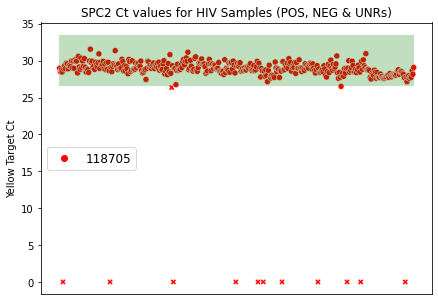

,Sample Count,# Valid,% Valid SPC2,95% CI LCB,95% CI UCB
Cartridge Lot,,,,,
118705,415,403,97.11%,95.00%,98.50%


In [65]:
##Step 5A: Generate SPC2 Ct performance Scatterplot by Cartridge Lot
plotFrame = concentrationFrame[concentrationFrame['Overall Result'].isin(['Positive','Negative','Unresolved'])].reset_index().set_index(['Condition','Cartridge Lot']).sort_index().reset_index('Cartridge Lot')
lot = '118705'
lots = ['118705']
fig, ax = plt.subplots(1,1,figsize=(7,5))
data = plotFrame.reset_index()#.loc[(plotFrame['Expected Concentration']>0)&(plotFrame['Expected Concentration']<7.99),:].reset_index()
#data = data[data[]
data = data.loc[data['Cartridge Lot'].isin([lot])]
#display(data)
x = np.arange(1,len(data)+1)
data

yup = 33.5
ylo = 26.5

data = data.sort_values('Cartridge Lot')
y = data['Yellow Target Ct'].fillna(0)
hue = data['Cartridge Lot']
data['Valid SPC2'] = np.where(((data['Yellow Target Ct']<yup)&
                              (data['Yellow Target Ct']>ylo)),1,0)

perc_detection_rate = "{0:.2%}".format(data['Valid SPC2'].mean())
data['Valid SPC2'] = data['Valid SPC2'].replace({0:'No', 1:'Yes'})
styleDict = {1:'',0:'x'}
style = data['Valid SPC2']

sns.scatterplot(x, y, color=colorDict[lots.index(lot)+1],style=style)

x = [0, len(data)]
#y = [data['Expected Concentration'].unique()[0],data['Expected Concentration'].unique()[0]]



ax.set_title('SPC2 Ct values for HIV Samples (POS, NEG & UNRs)')
ax.fill_between(x, yup, ylo,facecolor ='green', alpha = 0.25)

#ax.set_ylim(0,40)
legend_elements = []
newLabel = Line2D([0], [0], color=colorDict[lots.index(lot)+1], marker='o', linestyle='None',label=lot)
legend_elements.append(newLabel)

ax.legend(handles=legend_elements, fontsize=12,loc='center left')
plt.xticks([])

plt.show()
data['Valid SPC2'] = data['Valid SPC2'].replace({'No':0, 'Yes':1})
aggtable = data[['Cartridge Lot','Valid SPC2']].groupby(['Cartridge Lot']).agg(['count','sum','mean'])

aggtable.columns = ['Sample Count','# Valid', '% Valid SPC2']
for lot in aggtable.index:
    lcb, ucb = proportion_confint(count=aggtable.loc[lot,'# Valid'], nobs=aggtable.loc[lot,'Sample Count'], alpha=(1-0.95), method='beta')
    aggtable.loc[lot, ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]

aggtable.style.format(subset=['% Valid SPC2', '95% CI LCB', '95% CI UCB'], formatter='{:.2%}')

,Condition,Cartridge Lot,N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Expected Concentration,Test Guid,Sample ID,Overall Result,Green Target Log Conc,...,Yellow Target Ct,Test Strip NeuMoDx Barcode,Capture Plate Barcode,Test Strip,EXT Plate,Absolute Bias,Bias,Bias < 0.5,Positive,Valid
0,1E3 IU/mL,118705,12000075,V739,2,3.0,52c86aa6-90b6-ec11-8689-5cf370a0070c,C32832,Positive,3.07,...,28.969999,010081427802017810116840 2100059 17221222,010081427802028410118175 2100476 17240315,116840,118175,0.07,0.07,1.0,1.0,1.0
1,1E3 IU/mL,118705,12000075,V739,3,3.0,6d244ba1-44b7-ec11-868d-5cf370a0070c,C32793,Positive,3.03,...,29.010000,010081427802017810116838 2100259 17221221,010081427802028410118175 2100488 17240315,116838,118175,0.03,0.03,1.0,1.0,1.0
2,1E3 IU/mL,118705,12000075,V739,3,3.0,5bed5a9d-5ab7-ec11-868d-5cf370a0070c,C32776,Positive,2.99,...,28.980000,010081427802017810116840 2100095 17221222,010081427802028410118175 2100003 17240315,116840,118175,0.01,-0.01,1.0,1.0,1.0
3,1E3 IU/mL,118705,12000075,V739,3,3.0,7704c4cf-7ab6-ec11-8689-5cf370a0070c,C32846,Positive,3.19,...,30.120001,010081427802017810116839 2100579 17221222,010081427802028410118174 2100258 17240314,116839,118174,0.19,0.19,1.0,1.0,1.0
4,1E3 IU/mL,118705,12000075,V739,7,3.0,89244ba1-44b7-ec11-868d-5cf370a0070c,C32792,Positive,3.04,...,28.969999,010081427802017810116838 2100259 17221221,010081427802028410118174 2100449 17240314,116838,118174,0.04,0.04,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,Negative,118705,N000009,V941,8,0.0,7b7c5a8f-a2b6-ec11-866b-1866da4c1375,E16069,Unresolved,NaN,...,NaN,010081427802017810116840 2100078 17221222,010081427802028410118174 2100095 17240314,116840,118174,NaN,NaN,NaN,NaN,0.0
411,Negative,118705,N000009,V941,9,0.0,827c5a8f-a2b6-ec11-866b-1866da4c1375,E16070,Negative,NaN,...,29.309999,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,0.0,1.0
412,Negative,118705,N000009,V941,10,0.0,897c5a8f-a2b6-ec11-866b-1866da4c1375,E16071,Unresolved,NaN,...,26.350000,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,NaN,0.0
413,Negative,118705,N000009,V941,11,0.0,907c5a8f-a2b6-ec11-866b-1866da4c1375,E16072,Unresolved,NaN,...,NaN,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,NaN,0.0


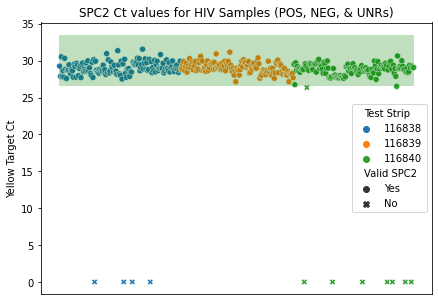

,Sample Count,# Valid,% Valid SPC2,95% CI LCB,95% CI UCB
Test Strip,,,,,
116838,142,138,97.18%,92.94%,99.23%
116839,132,132,100.00%,97.24%,100.00%
116840,141,133,94.33%,89.13%,97.52%


In [66]:
##Step 5B: Generate SPC2 Ct performance Scatterplot grouping by Test Strip Lot
plotFrame = concentrationFrame[concentrationFrame['Overall Result'].isin(['Positive','Negative','Unresolved'])].reset_index().set_index(['Condition','Cartridge Lot']).sort_index().reset_index('Cartridge Lot')
lot = '116838'
lots = ['116838', '116839', '116840']
fig, ax = plt.subplots(1,1,figsize=(7,5))
data = plotFrame.reset_index()#.loc[(plotFrame['Expected Concentration']>0)&(plotFrame['Expected Concentration']<7.99),:].reset_index()
#data = data[data[]
data = data.loc[data['Test Strip'].isin(lots)]
display(data)
x = np.arange(1,len(data)+1)
data

yup = 33.5
ylo = 26.5

data = data.sort_values('Test Strip')
y = data['Yellow Target Ct'].fillna(0)
hue = data['Test Strip']
data['Valid SPC2'] = np.where(((data['Yellow Target Ct']<yup)&
                              (data['Yellow Target Ct']>ylo)),1,0)

perc_detection_rate = "{0:.2%}".format(data['Valid SPC2'].mean())
data['Valid SPC2'] = data['Valid SPC2'].replace({0:'No', 1:'Yes'})
styleDict = {1:'',0:'x'}
style = data['Valid SPC2']

sns.scatterplot(x, y, hue=hue,style=style)

x = [0, len(data)]
#y = [data['Expected Concentration'].unique()[0],data['Expected Concentration'].unique()[0]]



ax.set_title('SPC2 Ct values for HIV Samples (POS, NEG, & UNRs)')
ax.fill_between(x, yup, ylo,facecolor ='green', alpha = 0.25)

#ax.set_ylim(0,40)
#legend_elements = []
#newLabel = Line2D([0], [0], color=colorDict[lots.index(lot)+1], marker='o', linestyle='None',label=lot)
#legend_elements.append(newLabel)

#ax.legend(handles=legend_elements, fontsize=12,loc='center left')
plt.xticks([])

plt.show()
data['Valid SPC2'] = data['Valid SPC2'].replace({'No':0, 'Yes':1})
aggtable = data[['Test Strip','Valid SPC2']].groupby(['Test Strip']).agg(['count','sum','mean'])

aggtable.columns = ['Sample Count','# Valid', '% Valid SPC2']
for lot in aggtable.index:
    lcb, ucb = proportion_confint(count=aggtable.loc[lot,'# Valid'], nobs=aggtable.loc[lot,'Sample Count'], alpha=(1-0.95), method='beta')
    aggtable.loc[lot, ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]

aggtable.style.format(subset=['% Valid SPC2', '95% CI LCB', '95% CI UCB'], formatter='{:.2%}')

,Condition,Cartridge Lot,N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Expected Concentration,Test Guid,Sample ID,Overall Result,Green Target Log Conc,...,Test Strip NeuMoDx Barcode,Capture Plate Barcode,Test Strip,EXT Plate,Absolute Bias,Bias,Bias < 0.5,Positive,Valid,Test Strip / EXT Plate
0,1E3 IU/mL,118705,12000075,V739,2,3.0,52c86aa6-90b6-ec11-8689-5cf370a0070c,C32832,Positive,3.07,...,010081427802017810116840 2100059 17221222,010081427802028410118175 2100476 17240315,116840,118175,0.07,0.07,1.0,1.0,1.0,116840 / 118175
1,1E3 IU/mL,118705,12000075,V739,3,3.0,6d244ba1-44b7-ec11-868d-5cf370a0070c,C32793,Positive,3.03,...,010081427802017810116838 2100259 17221221,010081427802028410118175 2100488 17240315,116838,118175,0.03,0.03,1.0,1.0,1.0,116838 / 118175
2,1E3 IU/mL,118705,12000075,V739,3,3.0,5bed5a9d-5ab7-ec11-868d-5cf370a0070c,C32776,Positive,2.99,...,010081427802017810116840 2100095 17221222,010081427802028410118175 2100003 17240315,116840,118175,0.01,-0.01,1.0,1.0,1.0,116840 / 118175
3,1E3 IU/mL,118705,12000075,V739,3,3.0,7704c4cf-7ab6-ec11-8689-5cf370a0070c,C32846,Positive,3.19,...,010081427802017810116839 2100579 17221222,010081427802028410118174 2100258 17240314,116839,118174,0.19,0.19,1.0,1.0,1.0,116839 / 118174
4,1E3 IU/mL,118705,12000075,V739,7,3.0,89244ba1-44b7-ec11-868d-5cf370a0070c,C32792,Positive,3.04,...,010081427802017810116838 2100259 17221221,010081427802028410118174 2100449 17240314,116838,118174,0.04,0.04,1.0,1.0,1.0,116838 / 118174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,Negative,118705,N000009,V941,8,0.0,7b7c5a8f-a2b6-ec11-866b-1866da4c1375,E16069,Unresolved,NaN,...,010081427802017810116840 2100078 17221222,010081427802028410118174 2100095 17240314,116840,118174,NaN,NaN,NaN,NaN,0.0,116840 / 118174
411,Negative,118705,N000009,V941,9,0.0,827c5a8f-a2b6-ec11-866b-1866da4c1375,E16070,Negative,NaN,...,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,0.0,1.0,116840 / 118175
412,Negative,118705,N000009,V941,10,0.0,897c5a8f-a2b6-ec11-866b-1866da4c1375,E16071,Unresolved,NaN,...,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,NaN,0.0,116840 / 118175
413,Negative,118705,N000009,V941,11,0.0,907c5a8f-a2b6-ec11-866b-1866da4c1375,E16072,Unresolved,NaN,...,010081427802017810116840 2100078 17221222,010081427802028410118175 2100438 17240315,116840,118175,NaN,NaN,NaN,NaN,0.0,116840 / 118175


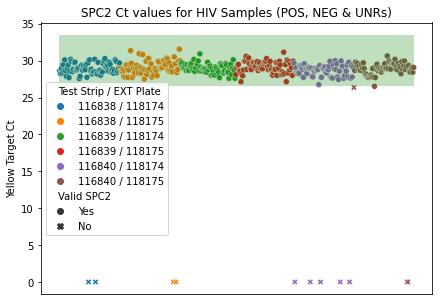

,Sample Count,# Valid,% Valid SPC2,95% CI LCB,95% CI UCB
Test Strip / EXT Plate,,,,,
116838 / 118174,71,69,97.18%,90.19%,99.66%
116838 / 118175,71,69,97.18%,90.19%,99.66%
116839 / 118174,64,64,100.00%,94.40%,100.00%
116839 / 118175,68,68,100.00%,94.72%,100.00%
116840 / 118174,70,65,92.86%,84.11%,97.64%
116840 / 118175,71,68,95.77%,88.14%,99.12%


In [67]:
##Step 5C: Generate SPC2 Ct performance Scatterplot grouping by Test Strip / EXT Plate Combination
plotFrame = concentrationFrame[concentrationFrame['Overall Result'].isin(['Positive','Negative','Unresolved'])].reset_index().set_index(['Condition','Cartridge Lot']).sort_index().reset_index('Cartridge Lot')
plotFrame['Test Strip / EXT Plate'] = plotFrame['Test Strip'] + " / " + plotFrame['EXT Plate']
lot = '116838'
lots = sorted(plotFrame['Test Strip / EXT Plate'].unique().tolist())
fig, ax = plt.subplots(1,1,figsize=(7,5))
data = plotFrame.reset_index()#.loc[(plotFrame['Expected Concentration']>0)&(plotFrame['Expected Concentration']<7.99),:].reset_index()
#data = data[data[]
data = data.loc[data['Test Strip / EXT Plate'].isin(lots)]
display(data)
x = np.arange(1,len(data)+1)
data

yup = 33.5
ylo = 26.5

data = data.sort_values('Test Strip / EXT Plate')
y = data['Yellow Target Ct'].fillna(0)
hue = data['Test Strip / EXT Plate']
data['Valid SPC2'] = np.where(((data['Yellow Target Ct']<yup)&
                              (data['Yellow Target Ct']>ylo)),1,0)

perc_detection_rate = "{0:.2%}".format(data['Valid SPC2'].mean())
data['Valid SPC2'] = data['Valid SPC2'].replace({0:'No', 1:'Yes'})
styleDict = {1:'',0:'x'}
style = data['Valid SPC2']

sns.scatterplot(x, y, hue=hue,style=style)

x = [0, len(data)]
#y = [data['Expected Concentration'].unique()[0],data['Expected Concentration'].unique()[0]]



ax.set_title('SPC2 Ct values for HIV Samples (POS, NEG & UNRs)')
ax.fill_between(x, yup, ylo,facecolor ='green', alpha = 0.25)

#ax.set_ylim(0,40)
#legend_elements = []
#newLabel = Line2D([0], [0], color=colorDict[lots.index(lot)+1], marker='o', linestyle='None',label=lot)
#legend_elements.append(newLabel)

#ax.legend(handles=legend_elements, fontsize=12,loc='center left')
plt.xticks([])

plt.show()
data['Valid SPC2'] = data['Valid SPC2'].replace({'No':0, 'Yes':1})
aggtable = data[['Test Strip / EXT Plate','Valid SPC2']].groupby(['Test Strip / EXT Plate']).agg(['count','sum','mean'])

aggtable.columns = ['Sample Count','# Valid', '% Valid SPC2']
for lot in aggtable.index:
    lcb, ucb = proportion_confint(count=aggtable.loc[lot,'# Valid'], nobs=aggtable.loc[lot,'Sample Count'], alpha=(1-0.95), method='beta')
    aggtable.loc[lot, ['95% CI LCB', '95% CI UCB']] = [lcb, ucb]

aggtable.style.format(subset=['% Valid SPC2', '95% CI LCB', '95% CI UCB'], formatter='{:.2%}')

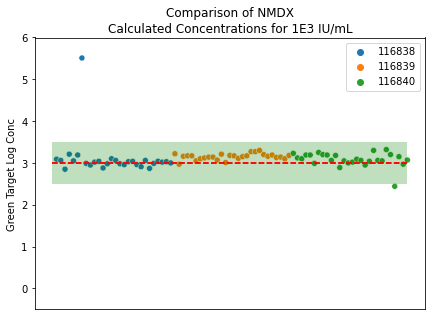

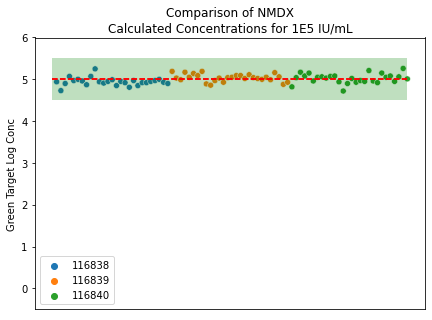

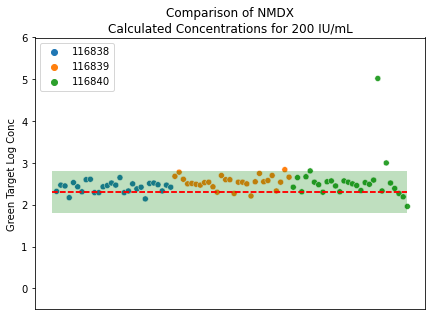

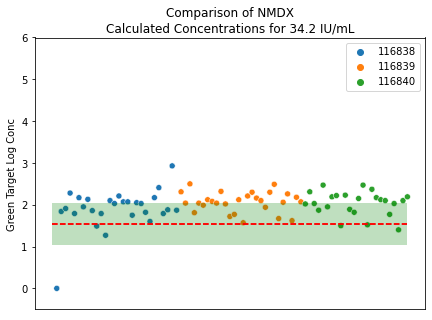

In [68]:
#Step 6: Generate Quanitative performance Scatterplot Summaries
plotFrame = concentrationFrame[concentrationFrame['Overall Result'].isin(['Positive','Negative'])].reset_index().set_index(['Condition','Cartridge Lot']).sort_index().reset_index('Cartridge Lot')

lot = '116838'
lots = ['116838','116839','116840']
for condition in plotFrame.index.unique(0):
    if 'mL' in condition and 'IU' in condition:
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        data = plotFrame.loc[condition].reset_index()
        
        data = data.loc[data['Test Strip'].isin(lots)]
        
        #isplay(data)
        #display(data)
        data = data.sort_values('Test Strip')
        x = np.arange(1,len(data)+1)
        
        y = data['Green Target Log Conc'].fillna(0)
        hue = data['Test Strip']
        sns.scatterplot(x, y, hue=hue)

        x = [0, len(data)]
        print()
        y = [data['Expected Concentration'].unique()[0],data['Expected Concentration'].unique()[0]]
        yup = [data['Expected Concentration'].unique()[0]+0.5,data['Expected Concentration'].unique()[0]+0.5]
        ylo = [data['Expected Concentration'].unique()[0]-0.5,data['Expected Concentration'].unique()[0]-0.5]
        sns.lineplot(x,y,color='r',linestyle='--')
        sns.lineplot(x,y,color='r',linestyle='--')
        ax.set_title('Comparison of NMDX\nCalculated Concentrations for '+condition,)
        ax.fill_between(x, yup, ylo,facecolor ='green', alpha = 0.25)
        ax.set_ylim(-0.5,6)
        #egend_elements = []
        #ewLabel = Line2D([0], [0], color=colorDict[lots.index(lot)+1], marker='o', linestyle='None',label=lot)
        #egend_elements.append(newLabel)

        #x.legend(handles=legend_elements, fontsize=12,loc='lower left')
        plt.xticks([])
        


        plt.show()

                                  OLS Regression Results                                 
Dep. Variable:     NMDX_Calculated_Concentration   R-squared:                       0.943
Model:                                       OLS   Adj. R-squared:                  0.943
Method:                            Least Squares   F-statistic:                     5449.
Date:                           Fri, 08 Apr 2022   Prob (F-statistic):          2.18e-206
Time:                                   16:07:25   Log-Likelihood:                -43.032
No. Observations:                            330   AIC:                             90.06
Df Residuals:                                328   BIC:                             97.66
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

Text(0.5, 1.0, 'NMDX Calculated Concentration vs Expected Concentration')

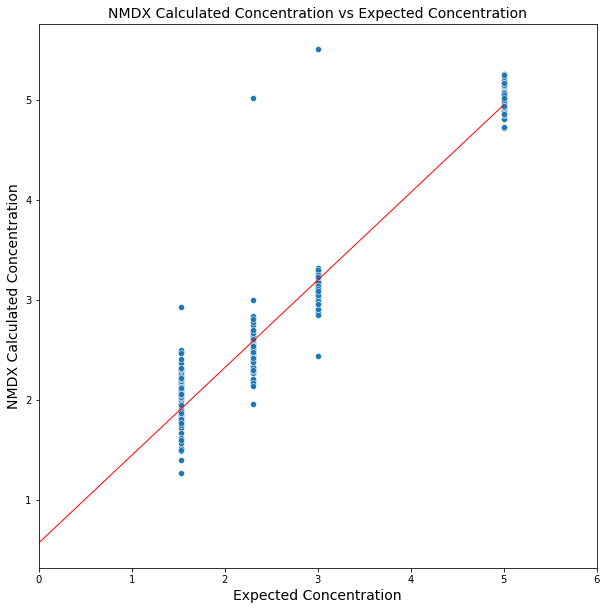

In [69]:
##Step 7 Linearity Evaluation (Using Ordinary Least Squares)
import statsmodels.api as sm
import statsmodels.formula.api as smf
fig, ax = plt.subplots(1,1, figsize=(10,10))
plotFrame['Expected_Concentration'] = plotFrame['Expected Concentration']
plotFrame['NMDX_Calculated_Concentration'] = plotFrame['Green Target Log Conc']
lm = smf.ols(formula='NMDX_Calculated_Concentration ~ Expected_Concentration', data=plotFrame[plotFrame['Expected Concentration']>0]).fit()
x_new = pd.DataFrame({'Expected_Concentration': [0, 5]}) 
pred = lm.predict(x_new)
print(lm.summary())
ax.plot([x_new.loc[0].values[0], x_new.loc[1].values[0]], [pred[0], pred[1]], c='red', linewidth=1)


sns.scatterplot(x='Expected Concentration', y='Green Target Log Conc', data=plotFrame[plotFrame['Expected Concentration']>0],ax=ax)
ax.set_xlim(0,6)
ax.set_ylabel('NMDX Calculated Concentration',fontsize=14)
ax.set_xlabel('Expected Concentration',fontsize=14)
ax.set_title("NMDX Calculated Concentration vs Expected Concentration",fontsize=14)

In [70]:
colorDict36  = {1:'#FF0000',#Red 1
              2:'#00B050',#Green 2
              3:'#0070C0',#Blue 3
              4:'#7030A0',#Purple 4
              5:'#808080',#Light Grey 5
              6:'#FF6600',#Orange 6
              7:'#FFCC00',#Yellow 7
              8:'#9999FF',#Light Purple 8
              9:'#333333',#Black 9
              10:'#808000',#Goldish 10
              11:'#FF99CC',#Hot Pink 11
              12:'#003300',#Dark Green 12
              13:'#FF0000',#Red 1
              14:'#00B050',#Green 2
              15:'#0070C0',#Blue 3
              16:'#7030A0',#Purple 4
              17:'#808080',#Light Grey 5
              18:'#FF6600',#Orange 6
              19:'#FFCC00',#Yellow 7
              20:'#9999FF',#Light Purple 8
              21:'#333333',#Black 9
              22:'#808000',#Goldish 10
              23:'#FF99CC',#Hot Pink 11
              24:'#003300',#Dark Green 12  
              25:'#FF0000',#Red 1
              26:'#00B050',#Green 2
              27:'#0070C0',#Blue 3
              28:'#7030A0',#Purple 4
              29:'#808080',#Light Grey 5
              30:'#FF6600',#Orange 6
              31:'#FFCC00',#Yellow 7
              32:'#9999FF',#Light Purple 8
              33:'#333333',#Black 9
              34:'#808000',#Goldish 10
              35:'#FF99CC',#Hot Pink 11
              36:'#003300',#Dark Green 12  
            }

styleDict36 = {1: 'solid',
              2: 'solid',
              3: 'solid',
              4: 'solid',
              5: 'solid',
              6: 'solid',
              7: 'solid',
              8: 'solid',
              9: 'solid',
              10: 'solid',
              11: 'solid',
              12: 'solid',
              13: 'dashed',
              14: 'dashed',
              15: 'dashed',
              16: 'dashed',
              17: 'dashed',
              18: 'dashed',
              19: 'dashed',
              20: 'dashed',
              21: 'dashed',
              22: 'dashed',
              23: 'dashed',
              24: 'dashed',
              25: 'dashdot',
              26: 'dashdot',
              27: 'dashdot',
              28: 'dashdot',
              29: 'dashdot',
              30: 'dashdot',
              31: 'dashdot',
              32: 'dashdot',
              33: 'dashdot',
              34: 'dashdot',
              35: 'dashdot',
              36: 'dashdot'}

Negative
34.2 IU/mL
200 IU/mL
1E3 IU/mL
1E5 IU/mL
HIV SPC2


<Figure size 432x288 with 0 Axes>

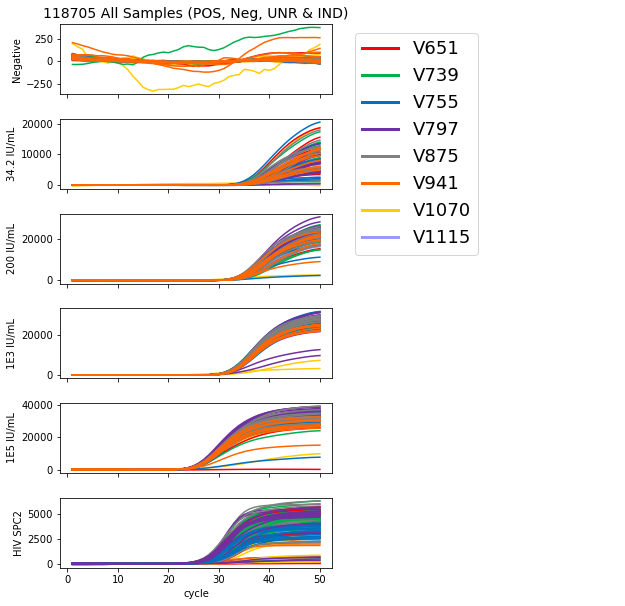

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [71]:
##Step 8A: Plot Amplification Curves for All Samples Included in Testing (All Samples)
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "")))#Define Channels to Include in Plots

##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Yellow', 'Green']

#Define Targets to Include in Plots
target_names = ['HIV', 'SPC2']

#Define Target / Channel Combinations
targets = {'Green':'HIV',
           'Yellow':'SPC2'}

channelData_Line = {}

amp_groups = ['Negative','34.2 IU/mL', '200 IU/mL', '1E3 IU/mL', '1E5 IU/mL',  'HIV SPC2']


channelDataDict = {}
channelData = {}    

channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()


channelData_Line['HIV SPC2'] = channelData['Yellow'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
channelData_Line['HIV SPC2']['Condition'] = 'HIV SPC2'


consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(len(amp_groups), len(lots)+1, figsize=(10,10),sharey='row',sharex=True)

for channel in amp_groups:
    print(channel)

    plt.subplots_adjust(wspace=0.05,hspace=0.35)
    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata.loc[~channelplotdata['Test Guid'].isin(exclude_list),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
    
    
    #display(channelplotdata)
    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    channelplotdata.set_index(['Test Guid'],append=True,inplace=True)
    for mod, run, lane, guid in channelplotdata.index.unique():

        
        if mod in mods:
            amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']
            try:
                if guid not in exclude_list:
                    #print(channelplotdata.loc[(mod,run,lane),'Test Guid'])
                    X = np.arange(1,51,1)
                    Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,51,1)]]
                    sns.lineplot(x=X,y=Y, color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],ax=axs[amp_groups.index(amp_group),lots.index(lot)])
                    axs[0,lots.index(lot)].set_title(lot + " All Samples (POS, Neg, UNR & IND)", fontsize=14, color='k')#colorDict36[treatments.index(treatment)+1])
            except:
                print(channelplotdata.loc[(mod,run,lane,guid)].index)
    
       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for mod in mods:
    newLabel = Line2D([0], [0], color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],lw=3,label=mod)
    legend_elements.append(newLabel)

axs[0,len(lots)].legend(handles=legend_elements, fontsize=18,loc='upper left', ncol=1)

## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(amp_groups)):
    axs[row,len(lots)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

Negative
34.2 IU/mL
200 IU/mL
1E3 IU/mL
1E5 IU/mL
HIV SPC2


<Figure size 432x288 with 0 Axes>

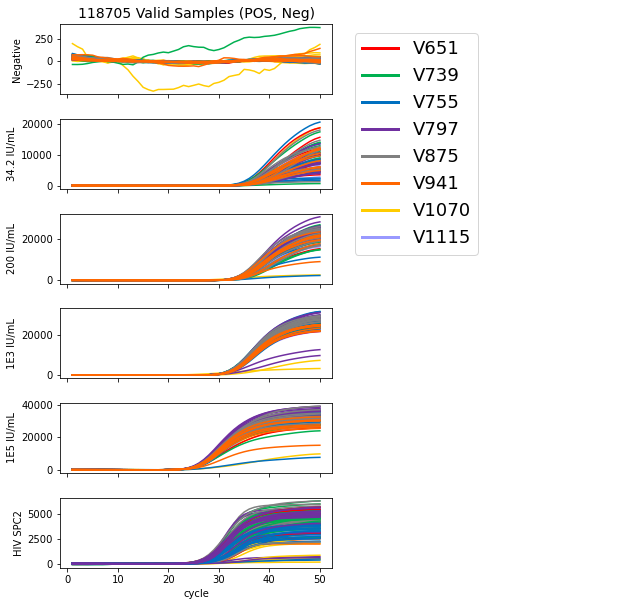

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [72]:
##Step 8B: Plot Amplification Curves for Valid Samples Included in Testing
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "")))#Define Channels to Include in Plots

##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Yellow', 'Green']

#Define Targets to Include in Plots
target_names = ['HIV', 'SPC2']

#Define Target / Channel Combinations
targets = {'Green':'HIV',
           'Yellow':'SPC2'}

channelData_Line = {}

amp_groups = ['Negative','34.2 IU/mL', '200 IU/mL', '1E3 IU/mL', '1E5 IU/mL',  'HIV SPC2']


channelDataDict = {}
channelData = {}    

channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()


channelData_Line['HIV SPC2'] = channelData['Yellow'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
channelData_Line['HIV SPC2']['Condition'] = 'HIV SPC2'



consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(len(amp_groups), len(lots)+1, figsize=(10,10),sharey='row',sharex=True)

for channel in amp_groups:
    print(channel)

    plt.subplots_adjust(wspace=0.05,hspace=0.35)
    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata.loc[~channelplotdata['Test Guid'].isin(exclude_list),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
    
    
    #display(channelplotdata)
    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    channelplotdata.set_index(['Test Guid'],append=True,inplace=True)
    channelplotdata = channelplotdata.loc[channelplotdata['Replicate Result'].isin(['Positive','Negative']),:]
    for mod, run, lane, guid in channelplotdata.index.unique():

        
        if mod in mods:
            amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']
            try:
                if guid not in exclude_list:
                    #print(channelplotdata.loc[(mod,run,lane),'Test Guid'])
                    X = np.arange(1,51,1)
                    Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,51,1)]]
                    sns.lineplot(x=X,y=Y, color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],ax=axs[amp_groups.index(amp_group),lots.index(lot)])
                    axs[0,lots.index(lot)].set_title(lot + " Valid Samples (POS, Neg)", fontsize=14, color='k')#colorDict36[treatments.index(treatment)+1])
            except:
                print(channelplotdata.loc[(mod,run,lane,guid)].index)
    
       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for mod in mods:
    newLabel = Line2D([0], [0], color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],lw=3,label=mod)
    legend_elements.append(newLabel)

axs[0,len(lots)].legend(handles=legend_elements, fontsize=18,loc='upper left', ncol=1)

## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(amp_groups)):
    axs[row,len(lots)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

Negative
34.2 IU/mL
200 IU/mL
1E3 IU/mL
1E5 IU/mL
HIV SPC2


<Figure size 432x288 with 0 Axes>

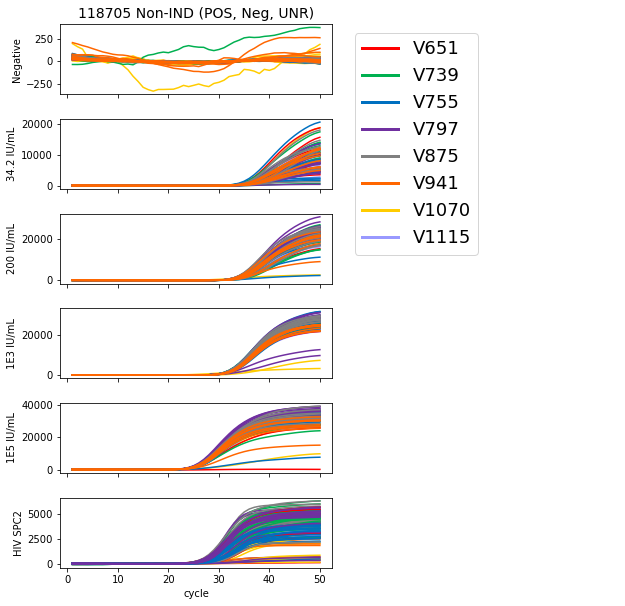

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [73]:
##Step 8C: Plot Amplification Curves for All Non-IND Samples Included in Testing
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "")))#Define Channels to Include in Plots

##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Yellow', 'Green']

#Define Targets to Include in Plots
target_names = ['HIV', 'SPC2']

#Define Target / Channel Combinations
targets = {'Green':'HIV',
           'Yellow':'SPC2'}

channelData_Line = {}

amp_groups = ['Negative','34.2 IU/mL', '200 IU/mL', '1E3 IU/mL', '1E5 IU/mL',  'HIV SPC2']



channelDataDict = {}
channelData = {}    

channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()


channelData_Line['HIV SPC2'] = channelData['Yellow'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
#channelData_Line['HIV SPC2'].dropna(subset=['Condition'],inplace=True)
channelData_Line['HIV SPC2']['Condition'] = 'HIV SPC2'


consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(len(amp_groups), len(lots)+1, figsize=(10,10),sharey='row',sharex=True)

for channel in amp_groups:
    print(channel)

    plt.subplots_adjust(wspace=0.05,hspace=0.35)
    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata.loc[~channelplotdata['Test Guid'].isin(exclude_list),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
    
    
    #display(channelplotdata)
    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    channelplotdata.set_index(['Test Guid'],append=True,inplace=True)
    channelplotdata = channelplotdata.loc[channelplotdata['Replicate Result'].isin(['Positive','Negative','Unresolved']),:]
    for mod, run, lane, guid in channelplotdata.index.unique():

        
        if mod in mods:
            amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']
            try:
                if guid not in exclude_list:
                    #print(channelplotdata.loc[(mod,run,lane),'Test Guid'])
                    X = np.arange(1,51,1)
                    Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,51,1)]]
                    sns.lineplot(x=X,y=Y, color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],ax=axs[amp_groups.index(amp_group),lots.index(lot)])
                    axs[0,lots.index(lot)].set_title(lot + " Non-IND (POS, Neg, UNR)", fontsize=14, color='k')#colorDict36[treatments.index(treatment)+1])
            except:
                print(channelplotdata.loc[(mod,run,lane,guid)].index)
    
       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for mod in mods:
    newLabel = Line2D([0], [0], color=colorDict36[mods.index(mod)+1],linestyle=styleDict36[mods.index(mod)+1],lw=3,label=mod)
    legend_elements.append(newLabel)

axs[0,len(lots)].legend(handles=legend_elements, fontsize=18,loc='upper left', ncol=1)

## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(amp_groups)):
    axs[row,len(lots)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()

In [77]:
##Step 9 Get Line Data
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
COC_PCR['Cartridge Serial'] = COC_PCR['Pcr Cartridge Barcode'].str[28:32]
COC_PCR['Extraction Plate Lot'] = COC_PCR['Capture Plate Barcode'].str[18:24]
COC_PCR['Test Strip Lot'] = COC_PCR['Test Strip NeuMoDx Barcode'].str[18:24]
COC_PCR['Buffer Lot'] = COC_PCR['Buffer Barcode'].str[18:24]
COC_PCR['Wash Lot'] = COC_PCR['Wash Reagent Barcode'].str[18:24]
COC_PCR['Release Lot'] = COC_PCR['Release Reagent Barcode'].str[18:24]

##Get Target Results from data
TargetResults = NormDataDict_PCR['Green'][['Target Result']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['Target Result']],lsuffix='Green',rsuffix='Yellow')

TargetResults.columns = ['Green Target Result', 'Yellow Target Result']
TargetResults.replace({'TargetAmplified':'AMP',
                       'TargetNotAmplified':'NotAmp',
                       'TargetIndeterminate':'IND',
                       'TargetUnresolved':'UNR',
                       'NoResult':'NR'},inplace=True)

EPRs = NormDataDict_PCR['Green'][['EPR']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['EPR']],lsuffix='Green',rsuffix='Yellow')
EPRs.columns = ['Green Target EPR', 'Yellow Target EPR']

MPHs = NormDataDict_PCR['Green'][['Max Peak Height']].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True).join(NormDataDict_PCR['Yellow'].reset_index(['XPCR Module Serial', 'Cartridge Lane'],drop=True)[['Max Peak Height']],lsuffix='Green',rsuffix='Yellow')
MPHs.columns = ['Green Target Max Peak Height', 'Yellow Target Max Peak Height']


TargetResults.index.names = ['Test Guid']



LineData = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).join(EPRs).join(MPHs).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
                       'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
                       'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target Flag', 'Yellow Target EP', 'Yellow Target EPR', 'Yellow Target Max Peak Height',
                       'Green Target Result', 'Green Target Ct', 'Green Target Flag', 'Green Target EP', 'Green Target EPR', 'Green Target Max Peak Height',
                       'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot','Expected Concentration']]\
                        .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])


LineData.sort_values(['Expected Concentration','Cartridge Serial','Pcr Cartridge Lane']).style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
                       'Pcr Cartridge Lane':'{:.0f}',
                       'Yellow Target Ct':'{:.2f}',
                       'Yellow Target EP':'{:.0f}',
                       'Yellow Target Max Peak Height':'{:.0f}',
                       'Yellow Target EPR':'{:.2f}',
                       'Green Target Ct':'{:.2f}',
                       'Green Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Orange Target Ct':'{:.2f}',
                       'Orange Target EP':'{:.0f}',
                       'Green Target Max Peak Height':'{:.0f}',
                       'Green Target EPR':'{:.2f}',
                       'Far Red Target Ct':'{:.2f}',
                       'Far Red Target EP':'{:.0f}',
                       'Far Red Target Max Peak Height':'{:.0f}',
                       'Far Red Target EPR':'{:.2f}',
                       'Red Target Ct':'{:.2f}',
                       'Red Target EP':'{:.0f}',
                       'Red Target Max Peak Height':'{:.0f}',
                       'Red Target EPR':'{:.2f}','Expected Concentration':'{:.2f}'
                                                                                                       
                       
                       },na_rep='-').hide_index()

N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Condition,Sample ID,Start Date Time,Cartridge Lot,Cartridge Serial,Overall Result,Yellow Target Result,Yellow Target Ct,Yellow Target Flag,Yellow Target EP,Yellow Target EPR,Yellow Target Max Peak Height,Green Target Result,Green Target Ct,Green Target Flag,Green Target EP,Green Target EPR,Green Target Max Peak Height,Buffer Lot,Extraction Plate Lot,Test Strip Lot,Wash Lot,Release Lot,Expected Concentration
N000009,V941,1,Negative,E16070,2022-04-07 14:46:26,118705,0039,Negative,AMP,28.82,-,4129,3.26,415,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.05,-,118055,118175,116840,113945,113222,0.00
N000009,V941,2,Negative,E16071,2022-04-07 14:46:26,118705,0039,Negative,AMP,28.70,-,5115,3.68,519,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118175,116840,113945,113222,0.00
N000009,V941,3,Negative,E16072,2022-04-07 14:46:26,118705,0039,Negative,AMP,29.53,-,3489,3.07,337,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118175,116840,113945,113222,0.00
N000009,V941,4,Negative,E16073,2022-04-07 14:46:26,118705,0039,Negative,AMP,28.68,-,4943,3.47,480,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118175,116840,113945,113222,0.00
N000009,V941,5,Negative,E16066,2022-04-07 14:43:06,118705,0039,Negative,AMP,26.74,-,1989,2.30,211,NotAmp,-,"1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",-,1.02,-,118055,118174,116840,113945,113222,0.00
N000009,V941,6,Negative,E16067,2022-04-07 14:43:06,118705,0039,Negative,AMP,28.94,-,4115,3.35,386,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118174,116840,113945,113222,0.00
N000009,V941,7,Negative,E16068,2022-04-07 14:43:06,118705,0039,Negative,AMP,28.95,-,3466,3.23,347,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118174,116840,113945,113222,0.00
N000009,V941,8,Negative,E16069,2022-04-07 14:43:06,118705,0039,Unresolved,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.38,-,UNR,-,"1020 (Informational, Peak Not Detected)",-,1.08,-,118055,118174,116840,113945,113222,0.00
N000009,V941,9,Negative,E16070,2022-04-07 14:43:06,118705,0039,Negative,AMP,29.31,-,3856,3.53,354,NotAmp,-,"1020 (Informational, Peak Not Detected)",-,1.04,-,118055,118175,116840,113945,113222,0.00
N000009,V941,10,Negative,E16071,2022-04-07 14:43:06,118705,0039,Unresolved,NotAmp,26.35,"1006 (Informational, Peak Location Failed)",1839,2.38,160,UNR,-,"1020 (Informational, Peak Not Detected)",-,1.19,-,118055,118175,116840,113945,113222,0.00


In [78]:
#Step 10 Get Line Data for Invalids
LineDataInvalids = COC_PCR.reset_index().set_index('Test Guid').join(TargetResults).loc[:,['N500 Serial Number', 'PCR Module Serial', 'Pcr Cartridge Lane', 'Condition', 'Sample ID',
                       'Start Date Time', 'Cartridge Lot', 'Cartridge Serial', 'Overall Result',
                       'Yellow Target Result', 'Yellow Target Ct', 'Yellow Target EP', 'Yellow Target Flag',
                       'Green Target Result', 'Green Target Ct', 'Green Target EP', 'Green Target Flag',
                       'Buffer Lot', 'Extraction Plate Lot', 'Test Strip Lot', 'Wash Lot', 'Release Lot']]\
                        .sort_values(['Cartridge Serial','Pcr Cartridge Lane'])

LineDataInvalids = LineDataInvalids.loc[~LineDataInvalids['Overall Result'].isin(['Positive', 'Negative'])]
LineDataInvalids.style.format({'Start Date Time':'{:%Y-%m-%d %H:%M:%S}',
                       'Pcr Cartridge Lane':'{:.0f}',
                       'Yellow Target Ct':'{:.2f}',
                       'Yellow Target EP':'{:.0f}',
                       'Green Target Ct':'{:.2f}',
                       'Green Target EP':'{:.0f}',
                       'Orange Target Ct':'{:.2f}',
                       'Orange Target EP':'{:.0f}',
                       'Far Red Target Ct':'{:.2f}',
                       'Far Red Target EP':'{:.0f}',
                       'Red Target Ct':'{:.2f}',
                       'Red Target EP':'{:.0f}',
                       
                       }).hide_index()

N500 Serial Number,PCR Module Serial,Pcr Cartridge Lane,Condition,Sample ID,Start Date Time,Cartridge Lot,Cartridge Serial,Overall Result,Yellow Target Result,Yellow Target Ct,Yellow Target EP,Yellow Target Flag,Green Target Result,Green Target Ct,Green Target EP,Green Target Flag,Buffer Lot,Extraction Plate Lot,Test Strip Lot,Wash Lot,Release Lot
N000009,V941,8,Negative,E16069,2022-04-07 14:43:06,118705,0039,Unresolved,NotAmp,nan,nan,"1020 (Informational, Peak Not Detected)",UNR,nan,nan,"1020 (Informational, Peak Not Detected)",118055,118174,116840,113945,113222
N000009,V941,10,Negative,E16071,2022-04-07 14:43:06,118705,0039,Unresolved,NotAmp,26.35,1839,"1006 (Informational, Peak Location Failed)",UNR,nan,nan,"1020 (Informational, Peak Not Detected)",118055,118175,116840,113945,113222
N000009,V941,11,Negative,E16072,2022-04-07 14:43:06,118705,0039,Unresolved,NotAmp,nan,nan,"1020 (Informational, Peak Not Detected)",UNR,nan,nan,"1020 (Informational, Peak Not Detected)",118055,118175,116840,113945,113222
N000009,V1070,5,34.2 IU/mL,A63986,2022-04-07 12:23:36,118705,3147,Indeterminate,NotAmp,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",IND,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",118055,118174,116840,113945,113222
N000009,V651,10,1E5 IU/mL,D21528,2022-04-07 12:26:59,118705,3148,Unresolved,NotAmp,nan,nan,"1020 (Informational, Peak Not Detected)",UNR,nan,nan,"1020 (Informational, Peak Not Detected)",118055,118174,116838,113945,113222
12000075,V755,1,34.2 IU/mL,A63989,2022-04-07 10:05:15,118705,3170,NoResult,NR,nan,nan,"2620 (Error, Maximum LhpC Reschedules Attempted), 1002 (Error, Insufficient Raw Readings)",NR,nan,nan,"2620 (Error, Maximum LhpC Reschedules Attempted), 1002 (Error, Insufficient Raw Readings)",118055,118175,116840,113945,117867
N000009,V1070,1,34.2 IU/mL,A63950,2022-04-08 10:04:26,118705,6348,Indeterminate,AMP,30.41,2199,None,IND,11.67,1394,"1040 (Informational, Derivative Data Filter Implemented), 1004 (Informational, Fixed Baseline Used), 1025 (Informational, Below EPR Threshold), 1031 (Error, EPR Threshold Not Met), 1037 (Informational, A very early amplification was potentially detected in the samples. It may be beneficial to dilute the starting sample 1:1000 and repeat.)",118055,118174,116840,113945,113222
12000075,V797,5,34.2 IU/mL,A63958,2022-04-08 10:13:20,118705,6429,Unresolved,NotAmp,nan,nan,"1020 (Informational, Peak Not Detected)",UNR,nan,nan,"1020 (Informational, Peak Not Detected)",118055,118174,116840,113945,117867
N000009,V651,6,Negative,E16067,2022-04-07 14:53:09,118705,6467,Indeterminate,NotAmp,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",IND,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",118055,118174,116838,113945,113222
N000009,V651,11,Negative,E16072,2022-04-07 14:53:09,118705,6467,Indeterminate,NotAmp,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected), 1039 (Informational, Overall EPR Threshold Check Failed)",IND,nan,nan,"1013 (Informational, Fill Check Failed), 1020 (Informational, Peak Not Detected)",118055,118175,116838,113945,113222


Negative
34.2 IU/mL
200 IU/mL
1E3 IU/mL
1E5 IU/mL
HIV SPC2


<Figure size 432x288 with 0 Axes>

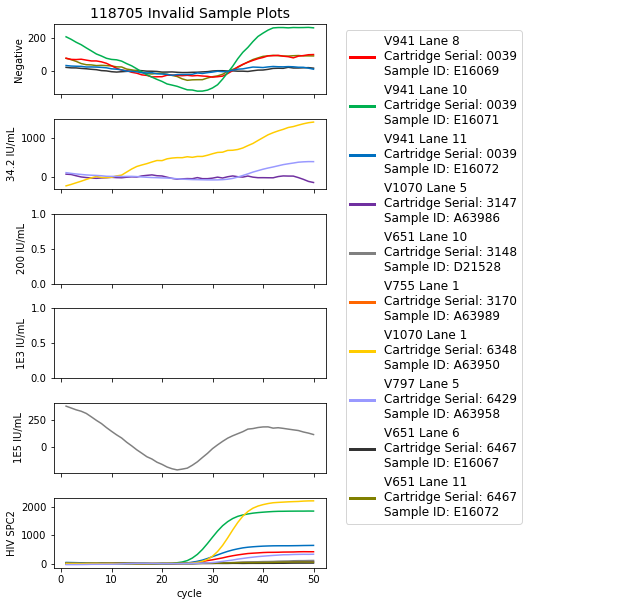

_ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _


In [76]:
invalid_samples = LineDataInvalids.index.unique(0).to_list()
##Step 11: Plot Amplification Curves for All Invalid Samples
COC_PCR['Cartridge Lot'] = COC_PCR['Pcr Cartridge Barcode'].str[18:24]
##Define Modules to Include in Plots
mods = sorted(COC_PCR.index.unique(0).dropna().to_list(), key= lambda x: int(x.replace("V", "").replace("EXP", "")))#Define Channels to Include in Plots

##Exclude samples by Test Guid
exclude_list = []

##Define Lots to Plot
lots = COC_PCR['Cartridge Lot'].unique().tolist()

#Define Channels to Plot
channels = ['Yellow', 'Green']

#Define Targets to Include in Plots
target_names = ['HIV', 'SPC2']

#Define Target / Channel Combinations
targets = {'Green':'HIV',
           'Yellow':'SPC2'}

channelData_Line = {}

amp_groups = ['Negative','34.2 IU/mL', '200 IU/mL', '1E3 IU/mL', '1E5 IU/mL',  'HIV SPC2']



channelDataDict = {}
channelData = {}    

channelData['Green'] = generateSummaryTable(NormDataDict_PCR['Green'], 'Green')
channelData['Yellow'] = generateSummaryTable(NormDataDict_PCR['Yellow'], 'Yellow')

for group in amp_groups:
    channelData_Line[group] = channelData['Green'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
    channelData_Line[group] = channelData_Line[group].loc[channelData_Line[group]['Condition']==group].sort_index()


channelData_Line['HIV SPC2'] = channelData['Yellow'][1].reset_index().set_index('Test Guid').join(COC_PCR.set_index('Test Guid')[['Condition']]).reset_index().set_index(['XPCR Module Serial', 'Run Number'])
#channelData_Line['HIV SPC2'].dropna(subset=['Condition'],inplace=True)
channelData_Line['HIV SPC2']['Condition'] = 'HIV SPC2'


consumables = generateLotTable(COC_PCR)
plt.subplots_adjust(wspace=0.05)

fig, axs = plt.subplots(len(amp_groups), len(lots)+1, figsize=(10,10),sharey='row',sharex=True)

for channel in amp_groups:
    print(channel)

    plt.subplots_adjust(wspace=0.05,hspace=0.35)
    channelData_Line[channel].loc[:,'Cartridge Lot'] = channelData_Line[channel].loc[:,'Cartridge Barcode'].str[18:24]
    channelplotdata = channelData_Line[channel]
    channelplotdata = channelplotdata.loc[channelplotdata['Test Guid'].isin(LineDataInvalids.index),:]
    channelplotdata = channelplotdata.dropna(subset=['Condition'])
    channelplotdata.reset_index(inplace=True)
    channelplotdata.set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane'],inplace=True)

    channelDataDict[channel] = channelplotdata.set_index(['Cartridge Lot', 'Condition'],append=True).loc[:,['Ct', 'Blank Reading', 'Dark Reading', 'Readings 5', 'End Point Fluorescence', 'Max Peak Height', 'EPR', 'Target Result', 'Test Guid', 'Replicate Result']]
    channelDataDict[channel] = channelDataDict[channel].reset_index().drop_duplicates(subset=['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition']).set_index(['XPCR Module Serial', 'Run Number', 'Cartridge Lane', 'Cartridge Lot', 'Condition'])
    channelDataDict[channel].columns = pd.MultiIndex.from_product([[channel],channelDataDict[channel].columns])
    
    
    
    #display(channelplotdata)
    if np.nan in channelplotdata.index.unique(0):
        channelplotdata.drop(np.nan,inplace=True,axis=0)
    
    channelplotdata.set_index(['Test Guid'],append=True,inplace=True)
    #channelplotdata = channelplotdata.loc[channelplotdata['Replicate Result'].isin(['Positive','Negative','Unresolved']),:]
    for mod, run, lane, guid in channelplotdata.index.unique():

        
        if mod in mods:
            amp_group = channelplotdata.loc[(mod,run,lane,guid), 'Condition']
            lot = channelplotdata.loc[(mod,run,lane,guid), 'Cartridge Lot']
            target = channelplotdata.loc[(mod,run,lane,guid), 'Target Name']
            if guid not in exclude_list:
                #print(channelplotdata.loc[(mod,run,lane),'Test Guid'])
                X = np.arange(1,51,1)
                Y = channelplotdata.loc[(mod,run,lane,guid), ['Readings '+str(read) for read in range(1,51,1)]]
                sns.lineplot(x=X,y=Y, color=colorDict36[invalid_samples.index(guid)+1],linestyle=styleDict36[invalid_samples.index(guid)+1],ax=axs[amp_groups.index(amp_group),lots.index(lot)])
                axs[0,lots.index(lot)].set_title(lot + " Invalid Sample Plots", fontsize=14, color='k')#colorDict36[treatments.index(treatment)+1])

       
for lot in lots:
    for amp_group in amp_groups:
        if amp_groups.index(amp_group) == len(amp_groups)-1:
                axs[amp_groups.index(amp_group),lots.index(lot)].set_xlabel('cycle')
        axs[amp_groups.index(amp_group),0].set_ylabel(amp_group)
            
    

legend_elements = []
for sample in invalid_samples:
    sampleInfo = COC_PCR[COC_PCR['Test Guid']==sample]
    sampleString = (sampleInfo.index.unique(0).values[0] + " Lane " +
                    str(int(sampleInfo.index.unique(1).values[0]))+"\nCartridge Serial: "+
                    sampleInfo['Cartridge Serial'].values[0]+"\nSample ID: "+
                    
                    sampleInfo['Sample ID'].values[0]
                   )
    newLabel = Line2D([0], [0], color=colorDict36[invalid_samples.index(sample)+1], linestyle=styleDict36[invalid_samples.index(sample)+1], lw=3,label=sampleString)
    legend_elements.append(newLabel)

axs[0,len(lots)].legend(handles=legend_elements, fontsize=12,loc='upper left', ncol=1)

## Use this if curves end up upside down, happens from time to time depending on how negative results look.
# for row in range(0,len(amp_groups)):
#     axs[row,0].invert_yaxis()
    


for row in range(0,len(amp_groups)):
    axs[row,len(lots)].axis('Off')
plt.show()
print("_ _"*30)
data = pd.concat([channelDataDict[df] for df in channelDataDict],axis=1).sort_index()